In [1]:
import os
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import pandas as pd
import numpy as np
from numpy import fft

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

### Load in Data

In [2]:
# Loads a dataset from a subdirectory.
def load_dataset(datapath):
    df = pd.DataFrame( )
    
    for folder in os.listdir(datapath):
        files = glob(pathname= str(datapath + folder + '/*.jpg'))
        df = pd.concat( [ df, pd.DataFrame( { 'filename': files , 
                                              'category': folder } ) ] )
    
    df = df.sort_values(by="category", ignore_index=True)    
       
    return df

In [3]:
train_path = 'seg_train/seg_train/'

training_set = load_dataset(train_path)

### Split Training Data into Train/Val

In [4]:
#Remove images that are not (150,150)
resolution_col = []
for idx, row in training_set.iterrows():
    img = plt.imread(row['filename'])
    if img.shape == (150, 150, 3):
        resolution_col.append('good')
    else:
        resolution_col.append('drop')
        
new_training_set = training_set.copy()
new_training_set['resolution'] = resolution_col
new_training_set.drop(new_training_set[new_training_set.resolution == "drop"].index, inplace=True)
# new_training_set = training_set.drop('resolution' == 'drop')
print("old", training_set.shape)
print("new", new_training_set.shape)

old (14034, 2)
new (13986, 3)


In [14]:
new_training_set = new_training_set.drop("resolution", axis = 1)
print(new_training_set.shape)

(13986, 2)


In [5]:
def train_val_split(training_set):
    '''Split a training set further into 80/20 train/validation subdatasets'''
    train, val = train_test_split(training_set, test_size=0.2, random_state = 314)
    return train, val

In [15]:
train, val = train_val_split(new_training_set) #split the training data into a training subset and validation set

In [16]:
def sanity_check_split(train, val):
    """Ensure multiclasses are still equally distributed after split"""
    
    print("New training df size: ", train.shape)
    print("New validation df size: ", val.shape)
    print("\n")
    train_class = train.groupby(['category']).count()/train.shape[0]
    val_class = val.groupby(['category']).count()/val.shape[0]
    print("New training class distribution: ", "\n", train_class)
    print("New validation class distribution: ", "\n", val_class)
    pass

In [17]:
sanity_check_split(train, val)

New training df size:  (11188, 2)
New validation df size:  (2798, 2)


New training class distribution:  
            filename
category           
buildings  0.155434
forest     0.163836
glacier    0.168305
mountain   0.178674
sea        0.161334
street     0.172417
New validation class distribution:  
            filename
category           
buildings  0.161187
forest     0.153681
glacier    0.180129
mountain   0.177269
sea        0.166190
street     0.161544


### Fourier Transform Filter

In [ ]:
def fourier_transform_3_examples(input_images):
    """Smaller function to show fourier transform and output example images - no windowing"""
    fig, ax = plt.subplots(3, 2, figsize=(15, 15))
    ax_row = 0
    ax_col = 0
    
    for idx, row in input_images.iterrows():
        img = plt.imread(row['filename'])
        img_gray = img.mean(axis=2) #make the image grayscale by averaging all 3 channels
        fourier = fft.fftshift(fft.fft2(img_gray))
        Fmag = np.abs(fourier)
        
        #plot the original and fourier images side-by-side
        ax[ax_row][ax_col].imshow(img)
        ax[ax_row][ax_col].set_title("original image of " + str(row['category']))
        ax[ax_row][ax_col].axis("off")
        ax_col += 1
        ax[ax_row][ax_col].imshow(np.log(Fmag), cmap='gray')
        ax[ax_row][ax_col].set_title("fourier transform of " + str(row['category']))
        ax[ax_row][ax_col].axis("off")
        ax_row += 1
        ax_col = 0
    pass

In [ ]:
# fourier_transform_3_examples(train.sample(n=3)) #Random samples, uncomment to run
fourier_transform_3_examples(train.iloc[:3,]) #First 3 samples in the training set

In [ ]:
def fourier_transform_3_examples_V2(input_images):
    """Smaller function to show fourier transform and output example images - WITH windowing to remove artifacts"""
    fig, ax = plt.subplots(3, 2, figsize=(15, 15))
    ax_row = 0
    ax_col = 0
    
    for idx, row in input_images.iterrows():
        img = plt.imread(row['filename'])
        ydim = img.shape[0]
        xdim = img.shape[1]
        img_gray = img.mean(axis=2) #make the image grayscale by averaging all 3 channels
        win = np.outer(np.hanning(ydim), np.hanning(xdim))
        win = win/np.mean(win)
        fourier = fft.fftshift(fft.fft2(img_gray*win))
        Fmag = np.abs(fourier)
        
        #plot the original and fourier images side-by-side
        ax[ax_row][ax_col].imshow(img)
        ax[ax_row][ax_col].set_title("original image of " + str(row['category']))
        ax[ax_row][ax_col].axis("off")
        ax_col += 1
        ax[ax_row][ax_col].imshow(np.log(Fmag), cmap='gray')
        ax[ax_row][ax_col].set_title("fourier transform of " + str(row['category']))
        ax[ax_row][ax_col].axis("off")
        ax_row += 1
        ax_col = 0
    pass

In [ ]:
# fourier_transform_3_examples_V2(train.sample(n=3)) #Random samples, uncomment to run
fourier_transform_3_examples_V2(train.iloc[:3,]) #First 3 samples in the training set

In [24]:
def fourier_transform(input_images):
    """Final fourier transform function that inputs a labeled dataset and 
    outputs an array of fourier transform filters and a list of labels"""
    featured_images = []
    
    for idx, row in input_images.iterrows():
        img = plt.imread(row['filename'])
        ydim = img.shape[0]
        xdim = img.shape[1]
        img_gray = img.mean(axis=2) #make the image grayscale by averaging all 3 channels
        win = np.outer(np.hanning(ydim), np.hanning(xdim))
        win = win/np.mean(win)
        fourier = fft.fftshift(fft.fft2(img_gray*win))
        Fmag = np.abs(fourier)
        featured_images.append(np.log(Fmag).flatten())
    
    featured_images_array = np.asarray(featured_images, dtype="object")
    print("featured images", featured_images_array.shape)
    labels = input_images.iloc[:,1].values.astype(str)

    return featured_images_array, labels

### Apply a Filter to Logistic Regression

In [27]:
def logistic_regression(train, val, feature):
    ''' Function to apply a feature to the validation set 
    and spit out error values (confusion matrix, precision, recall, F1 score, accuracy) '''
    #apply feature to train and validation images
    if feature == "fourier":
        train_featured, train_label = fourier_transform(train)
        val_featured, val_label = fourier_transform(val)
    else:
        pass # add different conditions for different features later
    
#     print("train images",train_featured.shape)
#     print("train labels",train_label.shape)
#     print("val images",val_featured.shape)
#     print("val labels",val_label.shape)
    
#     print("train images", train_featured)
#     print("train labels", train_label)
#     print("val images", val_featured)
#     print("val labels", val_label)
    
    #train and predict a multiclass logistic regression
    logisticRegr = LogisticRegression(multi_class='multinomial',solver='newton-cg')
    logisticRegr.fit(train_featured, train_label)
    predictions = logisticRegr.predict(val_featured)
    score = logisticRegr.score(val_featured, val_label)
    con_matrix = metrics.confusion_matrix(val_label, predictions)

    plt.figure(figsize=(9,9))
    sns.heatmap(con_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15);
    
    pass

featured images (500, 22500)
featured images (500, 22500)


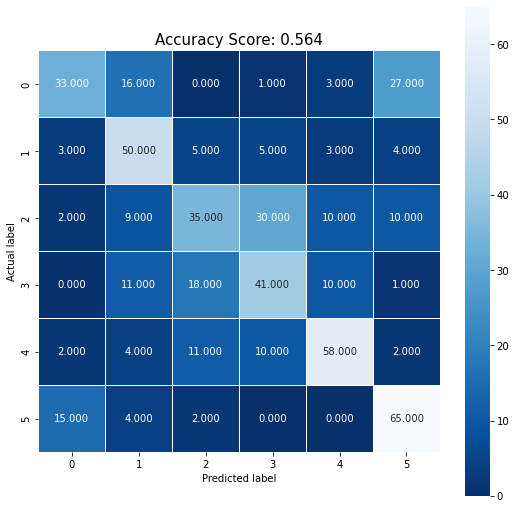

In [29]:
# logistic_regression(train, val, "fourier") #full dataset - uncomment to run
logistic_regression(train.iloc[:500], val.iloc[:500], "fourier") #trying a small sample for sanity check

## Apply a Filter to Random Forest

In [30]:
def random_forest(train, val, feature):
    ''' Function to apply a feature to the validation set 
    and spit out error values (confusion matrix, precision, recall, F1 score, accuracy) '''
    #apply feature to train and validation images
    if feature == "fourier":
        train_featured, train_label = fourier_transform(train)
        val_featured, val_label = fourier_transform(val)
    else:
        pass # add different conditions for different features later
    
#     print("train images",train_featured.shape)
#     print("train labels",train_label.shape)
#     print("val images",val_featured.shape)
#     print("val labels",val_label.shape)
    
    #train and predict a multiclass logistic regression
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    clf.fit(train_featured, train_label)
    predictions = clf.predict(val_featured)
    score = clf.score(val_featured, val_label)
    con_matrix = metrics.confusion_matrix(val_label, predictions)

    plt.figure(figsize=(9,9))
    sns.heatmap(con_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15);
    
    pass

featured images (500, 22500)
featured images (500, 22500)


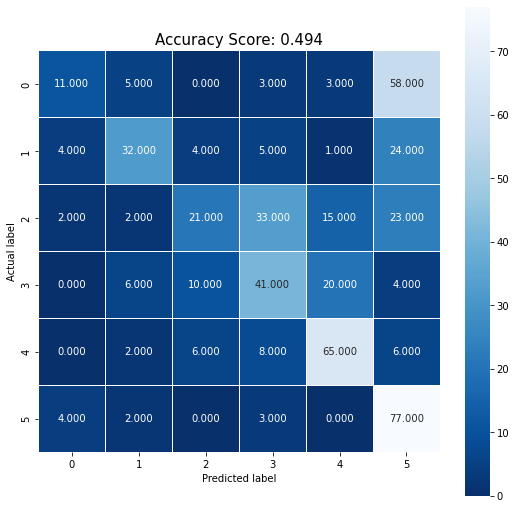

In [31]:
# random_forest(train, val, "fourier") #full dataset - uncomment to run
random_forest(train.iloc[:500], val.iloc[:500], "fourier") #trying a small sample for sanity check